In [12]:
import matplotlib.pyplot as plt
import numpy as np
# plt.style.use('_mpl-gallery')
import pandas as pd
import os
from matplotlib.colors import Normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import torch as T
import torch.linalg as LA
import os

In [13]:

class LID_processer:
    def __init__(self, LID_eval):
        self.LID_eval = T.tensor(LID_eval)
        self.grid = int(np.sqrt(LID_eval.shape[0]))
        
    @staticmethod
    def process_results(LID_eval, mode='TV', threshold=0.95):
        if mode == 'TV':
            # how many dimensions are needed to explain 95% of the variance    
            cumsum = T.cumsum(LID_eval, dim=1)
            LID_eval = (cumsum < threshold).sum(dim=1) + 1
        elif mode == 'MV':
            ## number of dimnesions larger than 5% of the variance
            print(LID_eval)
            LID_eval = (LID_eval >= (1-threshold)).sum(dim=1) 
            # print(LID_eval)
        elif mode == 'VR':
            ## compute the variance ratio
            delta_v = LID_eval[:, ] - T.concatenate((LID_eval[:, 1:], T.zeros((LID_eval.shape[0], 1))), dim=1)
            total_dv = T.sum(delta_v, dim=1)
            norm_delta_v = delta_v/total_dv.reshape(-1, 1)
            cumsum = T.cumsum(norm_delta_v, dim=1)
            LID_eval = (cumsum < threshold).sum(dim=1) + 1
            
        elif mode == 'percent':
            LID_eval = T.sum(LID_eval[:, :2], dim=1)
        else:
            raise ValueError('mode should be either dim or percent')
        return LID_eval           

    def plot_LID(self,  ax=None,  cmap='jet', mode='dim', threshold=0.95, prerun=False, range=None):
        LID_map = self.process_results(self.LID_eval, mode, threshold)
        LID_map = LID_map.reshape(self.grid, self.grid).to('cpu').numpy()

        map = np.flip(LID_map, axis=0)
        if prerun:
            return (map.min(), map.max())        

        if ax is None:
            # cbar of this plot
            if mode == 'percent':
                image = plt.imshow(map, cmap=cmap, norm=MidpointNormalize(midpoint=0.95, vmax=1)) 
                # continuous colorbar
                # plt.colorbar(image)
            else:
                self.discrete_matshow(map, cmap=cmap)

   
            # not show the ticks
            plt.xticks([])
            plt.yticks([])

        else:
            ax.set_xticks([])
            ax.set_yticks([])
            if mode == 'percent':
                # continuous colorbar
                # image = ax.imshow(map, cmap=cmap, norm=MidpointNormalize(midpoint=0.95, vmax=1))
                if range is not None:
                    image = ax.imshow(map, cmap=cmap, vmin=range[0], vmax=range[1])
                else:
                    image = ax.imshow(map, cmap=cmap, norm=MidpointNormalize(midpoint=0.95, vmax=1))
                # plt.colorbar(image, ax=ax)
                average = np.mean(map)
                ax.text(0.97, 0.03, f'{average:.2f}', color='k', transform=ax.transAxes, fontsize=12, ha='right')

            else:
                # discrete colorbar
                if range is not None:
                    image = self.discrete_matshow(map, cmap=cmap, ax=ax, range=range)
                else:
                    image = self.discrete_matshow(map, cmap=cmap, ax=ax)
                average = np.mean(map)
                # ax.set_title(f'Average LID: {average:.2f}')
                ax.text(0.97, 0.03, f'{average:.2f}', color='w', transform=ax.transAxes, fontsize=12, ha='right')

        return image
        

    @staticmethod     
    def discrete_matshow(data, cmap, ax=None, range=None):
    # get discrete colormap
        if range is not None:
            cmap = plt.get_cmap(cmap, range[1] - range[0] + 1)
        else:
            cmap = plt.get_cmap(cmap, np.max(data) - np.min(data) + 1)
        # set limits .5 outside true range
        if ax is None:
            if range is not None:
                mat = plt.imshow(data, cmap=cmap, vmin=range[0], vmax=range[1])
            else:
                mat = plt.imshow(data, cmap=cmap, vmin=np.min(data) - 0.5, 
                            vmax=np.max(data) + 0.5)
            # tell the colorbar to tick at integers
            cax = plt.colorbar(mat, ticks=np.arange(np.min(data), np.max(data) + 1))
        else:
            if range is not None:
                mat = ax.imshow(data, cmap=cmap, vmin=range[0], vmax=range[1])
            else:
                mat = ax.imshow(data, cmap=cmap, vmin=np.min(data) - 0.5, 
                            vmax=np.max(data) + 0.5)
            
            # tell the colorbar to tick at integers
            fig = ax.get_figure()
            # cax = fig.add_axes([0.95, 0.1, 0.03, 0.8])
            # plt.colorbar(mat,  ticks=np.arange(np.min(data), np.max(data) + 1))
            return mat
            
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y)) 



def plot_prob_map(labels, alpha, X_2d, y, ax=None, cmap=cm.tab10, epsilo=0.85, proba=True, ture_map=False, s=3):
    """Plot probability map for the classifier
    """

    n_class_max = max(labels)
    labels_normlized = labels/n_class_max
    map = cmap(labels_normlized)
    if proba:
        map[:, 3] = alpha 
    map[:, 3] *= epsilo  # plus a float to control the transparency
    grid = int(np.sqrt(labels.shape[0]))
    map =  map.reshape(grid, grid, 4)
    map = np.flip(map, 0)
    ax.imshow(map, interpolation='nearest', aspect='equal', extent=[0, 1, 0, 1])
    ax.set_facecolor('black')
    ax.set_xticks([])
    ax.set_yticks([])
    # set lim
    # ax.set_xlim(xx.min(), xx.max())
    # ax.set_ylim(yy.min(), yy.max())
    X_2d_scaled = MinMaxScaler().fit_transform(X_2d)
    ax.scatter(X_2d_scaled[:, 0], X_2d_scaled[:, 1], c=y, s=s, alpha=0.95, cmap=cmap, edgecolors='k', linewidths=0.1)

    return ax

def plot_GM(D):
    gird = int(np.sqrt(D.shape[0]))
    D = D.reshape(gird, gird)
    D = np.flip(D, axis=0)
    plt.imshow(D, cmap='jet')

In [14]:
# def plot_LID(dir, threshold=0.99, title=None):
#     DBM = np.load(dir + 'DBM_orig_torch.npz')
#     SDBM = np.load(dir + 'SSNP.npz')
#     DV = np.load(dir + 'DeepView_0.65.npz')
#     proj_name = ['DBM', 'SDBM', 'DV']
#     proj = [DBM, SDBM, DV]
#     row_names = ['Decsion Map', 'Local Intrinsic Dimensionality\n Axes needed to explain 99% variance', 'variance explained by the first 2 PCs']

#     fig, axes = plt.subplots(3, 3, figsize=(9, 10))

#     row1_min, row1_max = 1, 0
#     row2_min, row2_max = 1, 0
#     for j, ax_col in enumerate(axes.T):
        
#         for i, ax in enumerate(ax_col):
#             if j == 0:
#                 ax.set_ylabel(row_names[i])
#             if i == 0:
#                 ax.set_title(proj_name[j])
            
#             if i == 0:
#                 ax = plot_prob_map(proj[j]['labels'], proj[j]['alpha'], proj[j]['X_train_2d'], proj[j]['y_train'], ax=ax, epsilo=0.85, proba=True)
#             else:
#                 LID_holder = LID_processer(proj[j]['LID_evalues'])
#                 if i == 1:
#                     curmin, curmax=  LID_holder.plot_LID(ax=ax, mode='dim', threshold=threshold)
#                     row1_min = min(row1_min, curmin)
#                     row1_max = max(row1_max, curmax)
#                 elif i == 2:
#                     curmin, curmax = LID_holder.plot_LID(ax=ax, mode='percent', cmap='cividis', threshold=threshold)
#                     row2_min = min(row2_min, curmin)
#                     row2_max = max(row2_max, curmax)

#     ## set the same colorba

#     # plt.tight_layout()
#     fig.subplots_adjust(wspace=0.1, hspace=0.1)
#     if title is not None:
#         fig.suptitle(title, fontsize=16)
#     return fig
                


def plot_LID2(dir, threshold=0.95, title=None, mode1='MV', s=3):
    DBM = np.load(dir + 'DBM.npz')
    UMAP_iLAMP = np.load(dir + 'UMAP+iLAMP.npz')
    UMAP_RBF = np.load(dir + 'UMAP+RBF.npz')
    SDBM = np.load(dir + 'SDBM.npz')
    DV = np.load(dir + 'DeepView.npz', allow_pickle=True)
    MDS_iMDS = np.load(dir + 'MDS+iMDS.npz')
    proj_name = ['DBM (UMAP+NNinv)', 'SDBM', 'DeepView','UMAP+iLAMP', 'UMAP+RBF', 'MDS+iMDS' ]
    proj = [DBM, SDBM, DV, UMAP_iLAMP, UMAP_RBF, MDS_iMDS]
    row_names = ['Decsion Map', 'Estimated ID', 'Percentage of variance \naccounted for by the first 2 PCs', 'Gradient Map']

    fig, axes = plt.subplots(4, 6, figsize=(15.5, 10.4))
    minmax = {'row1': [2, 1], 'row2': [2, 1], 'row3': [2, 1], 'row4': [1, 0], 'row5': [1, 0], 'row6': [1, 0]}
    for j, ax_col in enumerate(axes.T):
        print(proj_name[j])
        for i, ax in enumerate(ax_col):
            if i == 0:
                # ax = plot_prob_map(proj[j]['labels'], proj[j]['alpha'], proj[j]['X_train_2d'], proj[j]['y_train'], ax=ax, epsilo=0.85, proba=True)
                pass
            else:
                LID_holder = LID_processer(proj[j]['LID_evalues'])
                if i == 1:
                    curmin, curmax =  LID_holder.plot_LID(ax=ax, mode=mode1, threshold=threshold, prerun=True)
                    # update the minmax
                    minmax[f'row{i}'][0] = min(minmax[f'row{i}'][0], curmin)
                    minmax[f'row{i}'][1] = max(minmax[f'row{i}'][1], curmax)
                elif i == 2:
                    curmin, curmax = LID_holder.plot_LID(ax=ax, mode='percent', cmap='cividis', threshold=threshold, prerun=True)
                    minmax[f'row{i}'][0] = min(minmax[f'row{i}'][0], curmin)
                    minmax[f'row{i}'][1] = max(minmax[f'row{i}'][1], curmax)

    
    for j, ax_col in enumerate(axes.T):
        for i, ax in enumerate(ax_col):
            if j == 0:
                ax.set_ylabel(row_names[i], rotation=90, ha='center', va='center')
                ax.yaxis.set_label_coords(-0.1, 0.5)
            if i == 0:
                ax.set_title(proj_name[j])
            
            if i == 0:
                
                ax = plot_prob_map(proj[j]['labels'], proj[j]['alpha'], proj[j]['X_train_2d'], proj[j]['y_train'], ax=ax, epsilo=0.85, proba=True, s=s)
                # ax = plot_prob_map(proj[j]['labels'], np.ones_like(proj[j]['labels']), proj[j]['X_train_2d'], proj[j]['y_train'], ax=ax, epsilo=0.85, proba=True)
            else:
                LID_holder = LID_processer(proj[j]['LID_evalues'])

                if i == 2:

                    ax = LID_holder.plot_LID(ax=ax, mode='percent', cmap='cividis', threshold=threshold, range=minmax[f'row{i}'])

                    if j == len(proj) - 1:
                        norm = colors.Normalize(vmin=minmax[f'row{i}'][0], vmax=minmax[f'row{i}'][1])

                        # print(minmax[f'row{i}'][0], minmax[f'row{i}'][1])
                        # cbar_dbm = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=minmax[f'row{i}'][0], vmax=minmax[f'row{i}'][1]), cmap='cividis'), ax=axes[i,:], orientation='vertical', shrink=0.9, aspect=20, pad=0.3, location='right')

                        # cbar_dbm.ax.tick_params(labelsize=8)
                        # cbar_dbm.ax.set_title('alpha', fontsize=8)
                        # set location of the colorbar  
                 
                        # cbar_ax = fig.add_axes([0.92, 0.3875, 0.01, 0.215])  # Specify position and size [0.92, 0.125, 0.01, 0.215]
                        
                        cbar_ax = fig.add_axes([0.904, 0.308, 0.006, 0.18])  # Specify position and size [0.92, 0.125, 0.01, 0.215]
                        cbar_dbm = fig.colorbar(ax, cax=cbar_ax)
                elif i == 1:
                    LID_holder.plot_LID(ax=ax, mode=mode1, threshold=threshold, range=minmax[f'row{i}'])

                    if j == len(proj) - 1:
                        vmin = minmax[f'row{i}'][0]
                        vmax = minmax[f'row{i}'][1]
                        # print(vmin, vmax)
                        cmap = plt.get_cmap('jet', vmax - vmin + 1)
                        f, a = plt.subplots(1, 1, figsize=(1, 5))
                        mat = a.imshow(np.array([[vmin, vmax]]), cmap=cmap, vmin=vmin-0.5, vmax=vmax+0.5)
                        cbar_ax = fig.add_axes([0.904, 0.501, 0.006, 0.18]) #
                        # cax = fig.colorbar(mat, ticks=np.arange(vmin, vmax + 1), cax=cbar_ax)
                        ticks = np.arange(vmin, vmax + 1)
                        # check if the ticks are too many, if so, reduce and make it intager
                        while len(ticks) > 10:
                            ticks = ticks[::2]
                        
                        cbar_dbm = fig.colorbar(mat, ticks=ticks, cax=cbar_ax)
                        

                elif i == 3:
                    GM = proj[j]['GM']
                    GM = GM.reshape(int(np.sqrt(GM.shape[0])), int(np.sqrt(GM.shape[0])))
                    GM = np.flip(GM, axis=0)
                    g_min = GM.min()
                    g_max = GM.max()
                    im = ax.imshow(GM, cmap='magma', vmin=g_min, vmax=g_max)
                    ax.set_xticks([])
                    ax.set_yticks([])
                    if GM.mean() < 1e5:
                        ax.text(0.97, 0.03, f'{GM.mean():.2f}', ha='right', va='bottom', fontsize=12, color='white', transform=ax.transAxes)
                    else:
                        ax.text(0.97, 0.03, f'{GM.mean():.2e}', ha='right', va='bottom', fontsize=12, color='white', transform=ax.transAxes)

                    ## get location of ax so that we can put the colorbar
                    ax_loc = ax.get_position()
                    print(ax_loc)
                    # colorbar for each
                    numb_cols = len(proj_name)
                    cbar_ax = fig.add_axes([ax_loc.x0 - 0.0033 * j +0.0005 , ax_loc.y0-0.012, ax_loc.width + 0.0155, 0.007])
                    # fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.0461, pad=0.01, cax=cbar_ax)
                    fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
            
               



        

    # plt.tight_layout()
    fig.subplots_adjust(wspace=0.02, hspace=0.02)
    if title is not None:
        fig.suptitle(title, fontsize=16, y=0.93)
    # plt.tight_layout()
    return fig

In [25]:
mode = 'MV'
save = True
threshold = 0.99

DBM (UMAP+NNinv)
tensor([[7.6423e-01, 2.3540e-01, 1.5800e-04,  ..., 2.5964e-05, 2.5579e-05,
         2.5302e-05],
        [7.7052e-01, 2.2910e-01, 1.8517e-04,  ..., 2.5467e-05, 2.5283e-05,
         2.5076e-05],
        [7.5918e-01, 2.4040e-01, 2.1852e-04,  ..., 2.5692e-05, 2.5417e-05,
         2.5331e-05],
        ...,
        [7.4526e-01, 2.5438e-01, 5.3795e-05,  ..., 4.3208e-05, 4.3192e-05,
         4.3172e-05],
        [7.5539e-01, 2.4425e-01, 5.4302e-05,  ..., 4.2877e-05, 4.2871e-05,
         4.2857e-05],
        [7.4880e-01, 2.5083e-01, 5.5376e-05,  ..., 4.3276e-05, 4.3254e-05,
         4.3225e-05]])
SDBM
tensor([[6.1011e-01, 3.8671e-01, 1.1575e-03,  ..., 2.8313e-04, 2.8051e-04,
         2.8015e-04],
        [6.0318e-01, 3.9363e-01, 1.1273e-03,  ..., 2.8697e-04, 2.8433e-04,
         2.8418e-04],
        [6.2585e-01, 3.7101e-01, 1.1089e-03,  ..., 2.8314e-04, 2.8064e-04,
         2.8058e-04],
        ...,
        [7.8982e-01, 2.0993e-01, 4.9233e-05,  ..., 2.6102e-05, 2.5882e-05,
   

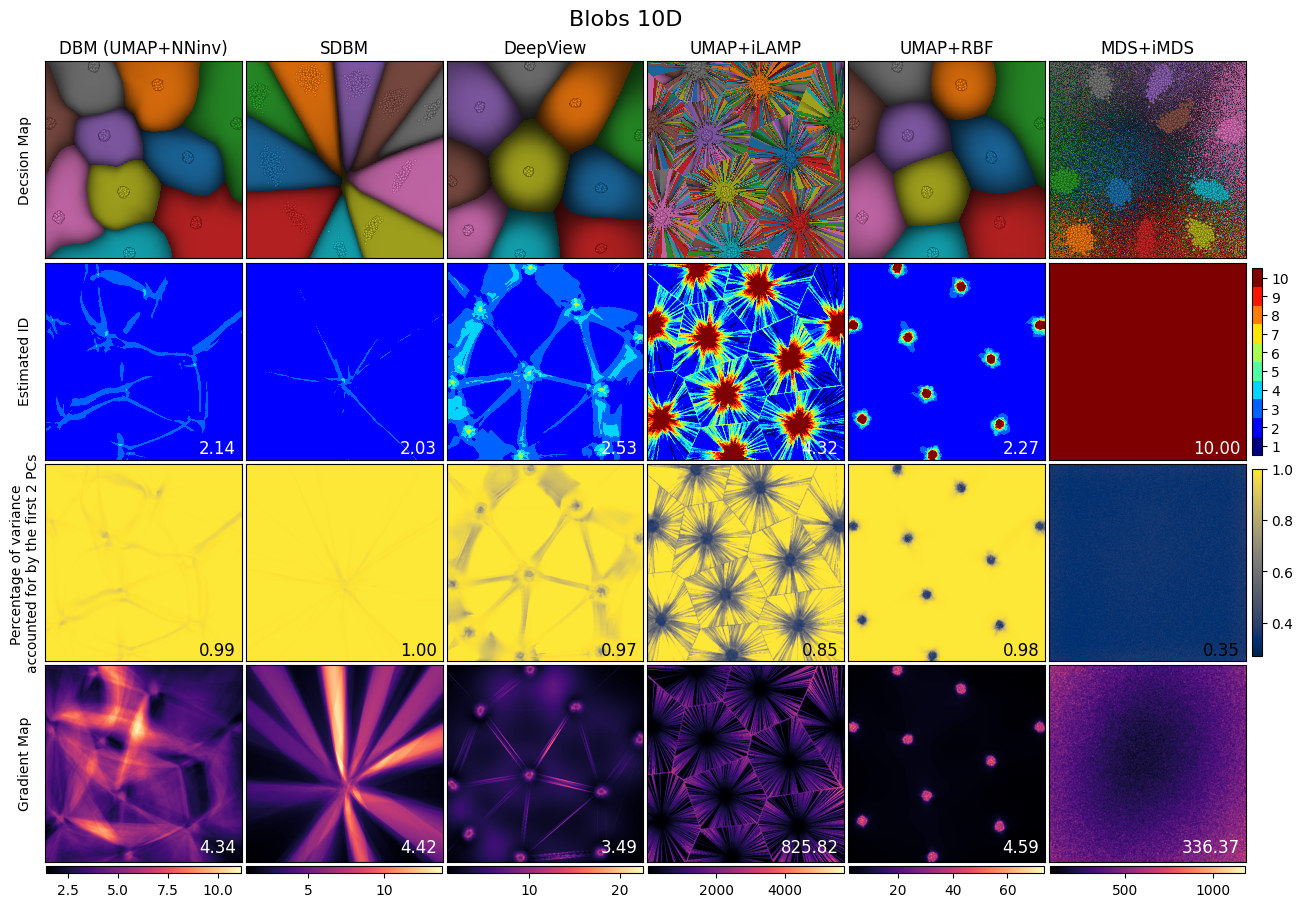

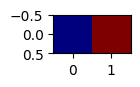

In [26]:
path = 'LID_results_new_grid500_GM_iMDS_global/blobs_dim10_n5000_y10_'
test = plot_LID2(path, threshold=threshold, title='Blobs 10D', mode1=mode)
# plt.tight_layout()

# test.savefig('figures/blobs_dim10_n5000_y10_.png', dpi=300, bbox_inches='tight')
if save:
    test.savefig('../paper/IVAPP24_extend_CCIS/figures/figure_CCIS/blobs_dim10_id_5cols.png', dpi=300, bbox_inches='tight')
# test.savefig('../paper/PAPER_intrinsic_dim/figures/blobs_dim10_id.pdf', dpi=300, bbox_inches='tight')

DBM (UMAP+NNinv)
tensor([[7.7916e-01, 2.1889e-01, 3.0558e-04,  ..., 5.5503e-05, 5.5493e-05,
         5.5489e-05],
        [7.6557e-01, 2.3231e-01, 3.9668e-04,  ..., 5.7961e-05, 5.7951e-05,
         5.7944e-05],
        [7.5087e-01, 2.4692e-01, 4.3103e-04,  ..., 5.9805e-05, 5.9798e-05,
         5.9796e-05],
        ...,
        [7.5707e-01, 2.4247e-01, 3.2414e-05,  ..., 1.5352e-05, 1.5329e-05,
         1.5275e-05],
        [7.7297e-01, 2.2659e-01, 2.9552e-05,  ..., 1.4942e-05, 1.4931e-05,
         1.4913e-05],
        [7.8666e-01, 2.1290e-01, 2.9902e-05,  ..., 1.4572e-05, 1.4535e-05,
         1.4457e-05]])
SDBM
tensor([[7.5700e-01, 2.3964e-01, 2.1022e-03,  ..., 3.8318e-05, 3.8298e-05,
         3.8276e-05],
        [7.5530e-01, 2.4141e-01, 2.0132e-03,  ..., 3.8800e-05, 3.8756e-05,
         3.8696e-05],
        [7.5231e-01, 2.4447e-01, 1.8919e-03,  ..., 3.8732e-05, 3.8694e-05,
         3.8650e-05],
        ...,
        [7.7411e-01, 2.2565e-01, 3.5584e-05,  ..., 6.4382e-06, 6.4371e-06,
   

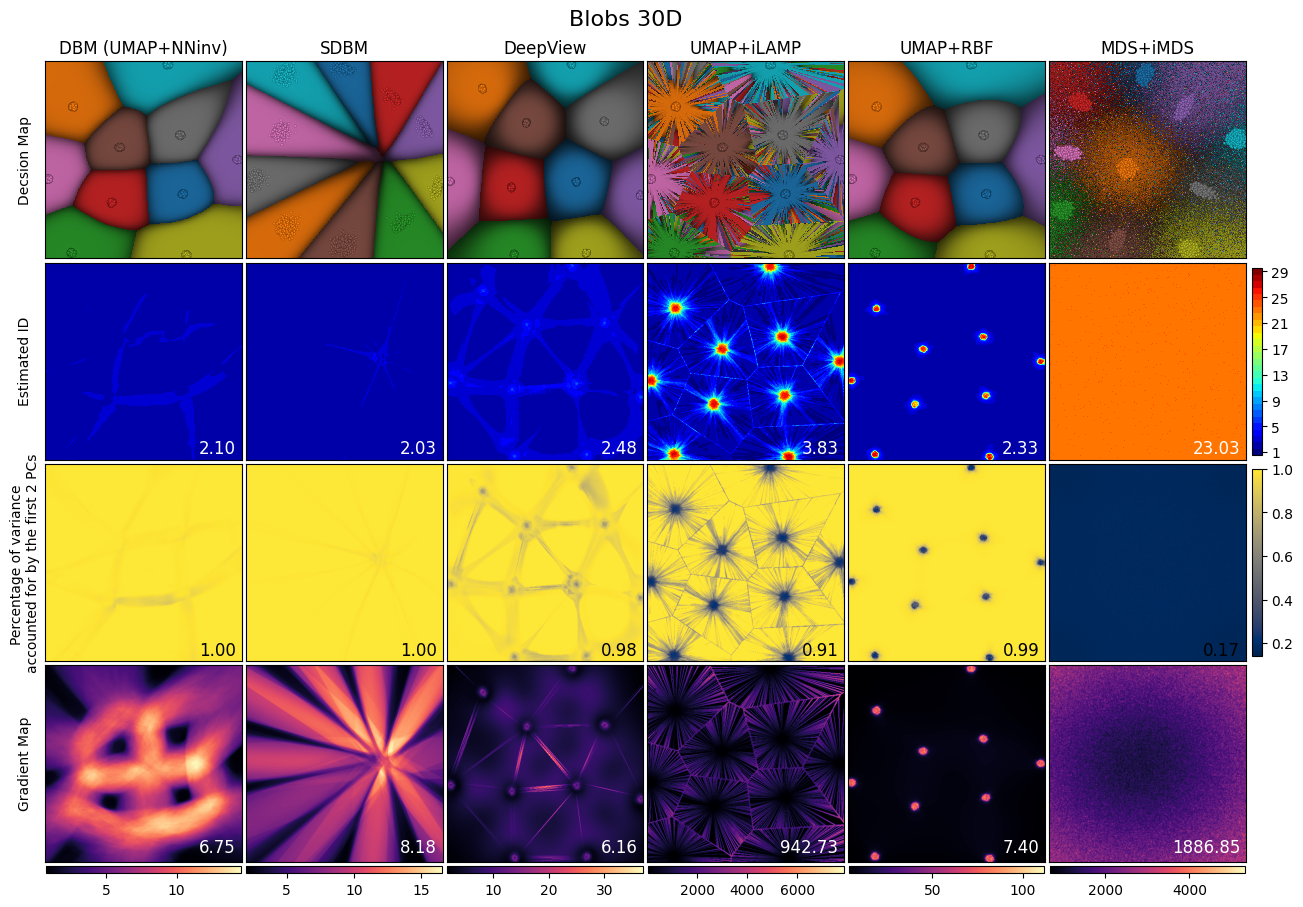

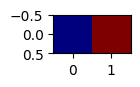

In [27]:
path = 'LID_results_new_grid500_GM_iMDS_global/blobs_dim30_n5000_y10_'
test = plot_LID2(path, threshold=threshold, title='Blobs 30D', mode1=mode)
# plt.tight_layout()
# test.savefig('figures/blobs_dim30_n5000_y10_.png', dpi=300, bbox_inches='tight')
# test.savefig('../paper/PAPER_intrinsic_dim/figures/blobs_dim30_id.pdf', dpi=300, bbox_inches='tight')
if save:
    test.savefig('../paper/IVAPP24_extend_CCIS/figures/figure_CCIS/blobs_dim30_id_5cols.png', dpi=300, bbox_inches='tight')

In [28]:
# path = 'LID_results_new_grid500_GM/blobs_dim60_n5000_y10_'
# test = plot_LID2(path, threshold=threshold, title='Blobs 60D', mode1=mode)
# # plt.tight_layout()
# # test.savefig('figures/blobs_dim100_n5000_y10_.png', dpi=300, bbox_inches='tight')
# # test.savefig('../paper/PAPER_intrinsic_dim/figures/blobs_dim100_id.pdf', dpi=300, bbox_inches='tight')
# if save:
#     test.savefig('../paper/IVAPP24_extend_CCIS/figures/figure_CCIS/blobs_dim60_id_5cols.png', dpi=300, bbox_inches='tight')

DBM (UMAP+NNinv)
tensor([[7.9086e-01, 2.0559e-01, 4.0488e-04,  ..., 3.1833e-05, 3.1819e-05,
         3.1784e-05],
        [7.8798e-01, 2.0842e-01, 4.5341e-04,  ..., 3.1693e-05, 3.1693e-05,
         3.1640e-05],
        [7.8102e-01, 2.1537e-01, 4.9362e-04,  ..., 3.1468e-05, 3.1468e-05,
         3.1432e-05],
        ...,
        [5.7605e-01, 4.1249e-01, 6.0368e-04,  ..., 1.1174e-04, 1.1174e-04,
         1.1174e-04],
        [5.2442e-01, 4.6385e-01, 6.2698e-04,  ..., 1.1428e-04, 1.1426e-04,
         1.1425e-04],
        [5.1231e-01, 4.7597e-01, 6.7111e-04,  ..., 1.1376e-04, 1.1374e-04,
         1.1373e-04]])
SDBM
tensor([[7.4731e-01, 2.5233e-01, 5.6209e-05,  ..., 2.6159e-06, 2.6113e-06,
         2.6031e-06],
        [7.2657e-01, 2.7307e-01, 5.1988e-05,  ..., 2.6710e-06, 2.6709e-06,
         2.6212e-06],
        [7.3353e-01, 2.6612e-01, 5.2563e-05,  ..., 2.6348e-06, 2.6254e-06,
         2.6027e-06],
        ...,
        [7.7154e-01, 2.2805e-01, 2.0891e-05,  ..., 3.6297e-06, 3.6273e-06,
   

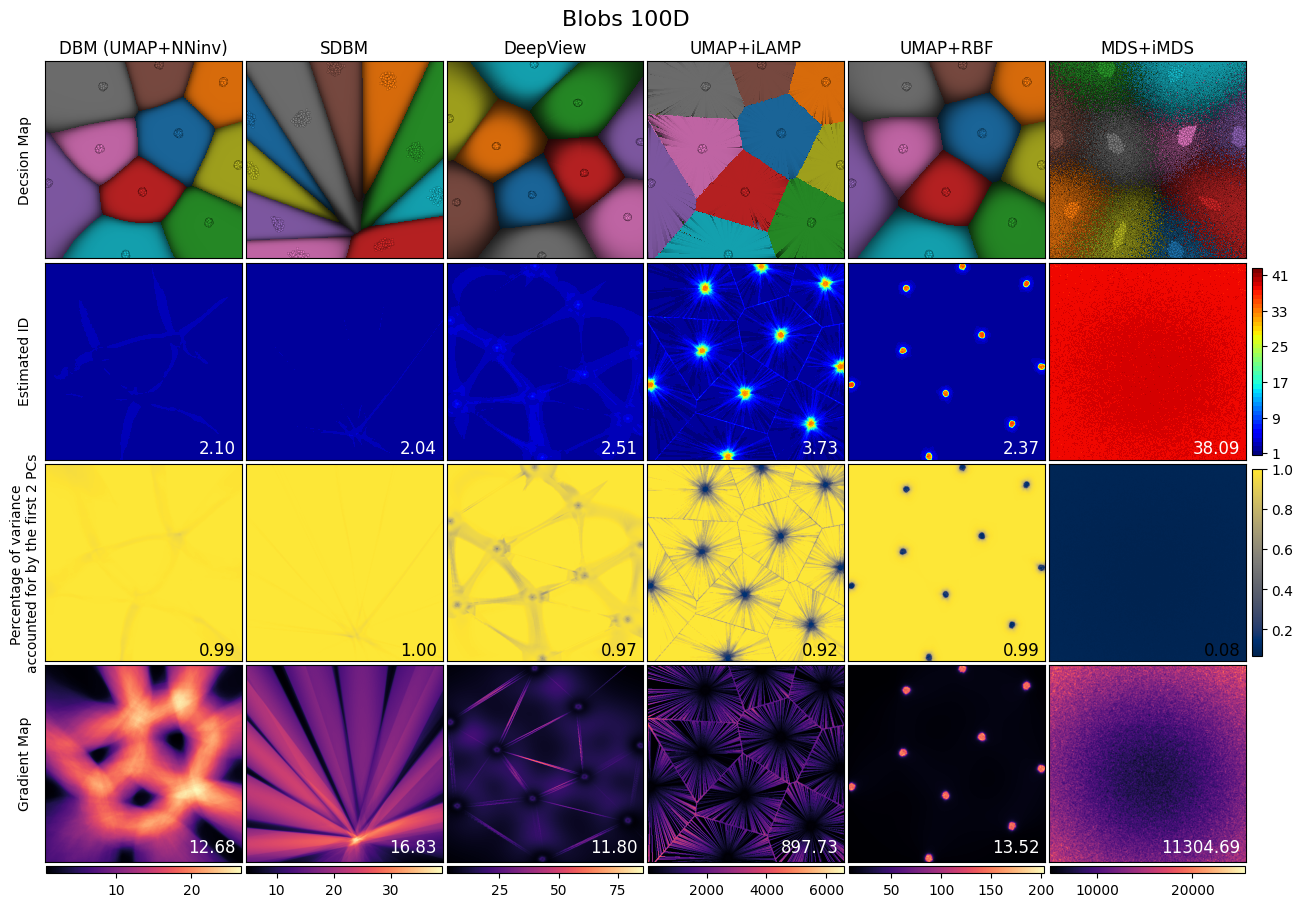

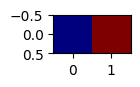

In [29]:
path = 'LID_results_new_grid500_GM_iMDS_global/blobs_dim100_n5000_y10_'
test = plot_LID2(path, threshold=threshold, title='Blobs 100D', mode1=mode)
# plt.tight_layout()
# test.savefig('figures/blobs_dim100_n5000_y10_.png', dpi=300, bbox_inches='tight')
# test.savefig('../paper/PAPER_intrinsic_dim/figures/blobs_dim100_id.pdf', dpi=300, bbox_inches='tight')
if save:
    test.savefig('../paper/IVAPP24_extend_CCIS/figures/figure_CCIS/blobs_dim100_id_5cols.png', dpi=300, bbox_inches='tight')

DBM (UMAP+NNinv)
tensor([[7.6386e-01, 2.3526e-01, 1.1896e-04,  ..., 1.1860e-06, 1.1673e-06,
         1.1577e-06],
        [7.5346e-01, 2.4564e-01, 1.2067e-04,  ..., 1.2590e-06, 1.2509e-06,
         1.2435e-06],
        [7.7015e-01, 2.2894e-01, 1.3789e-04,  ..., 1.2124e-06, 1.2029e-06,
         1.2013e-06],
        ...,
        [7.0849e-01, 2.8916e-01, 1.4255e-03,  ..., 9.8064e-07, 9.8040e-07,
         9.7909e-07],
        [7.1440e-01, 2.8345e-01, 1.2433e-03,  ..., 9.7963e-07, 9.7776e-07,
         9.6301e-07],
        [7.1535e-01, 2.8253e-01, 1.2005e-03,  ..., 9.7708e-07, 9.6673e-07,
         9.5490e-07]])
SDBM
tensor([[7.6499e-01, 2.3036e-01, 8.6330e-05,  ..., 8.0597e-06, 8.0499e-06,
         8.0379e-06],
        [7.6817e-01, 2.2718e-01, 9.2116e-05,  ..., 8.0306e-06, 8.0166e-06,
         8.0151e-06],
        [7.4942e-01, 2.4581e-01, 9.2558e-05,  ..., 8.2428e-06, 8.2359e-06,
         8.2129e-06],
        ...,
        [7.1427e-01, 2.8382e-01, 4.3585e-05,  ..., 3.2742e-06, 3.2725e-06,
   

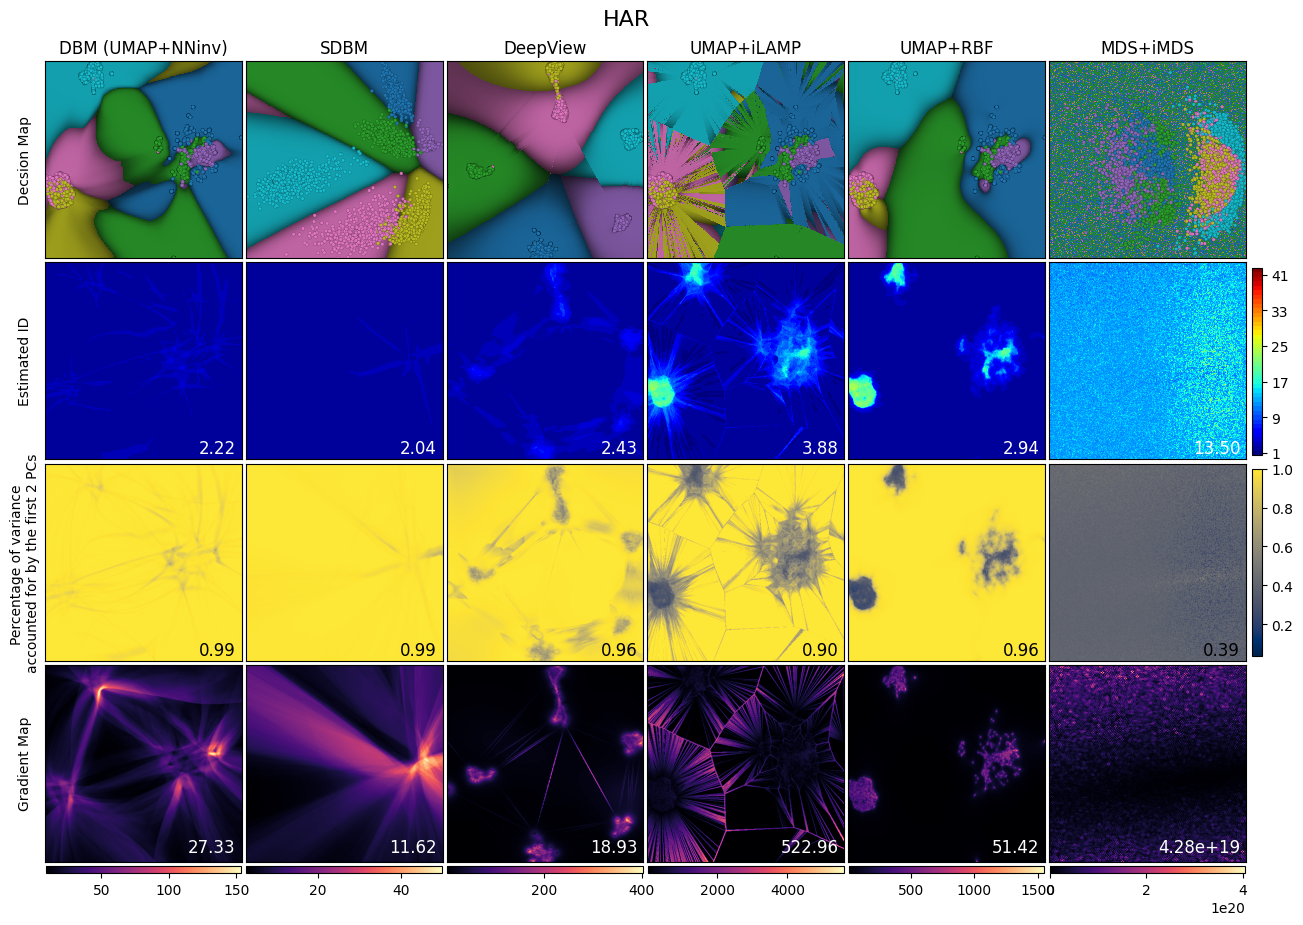

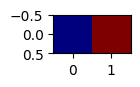

In [30]:
dim5 = plot_LID2('./LID_results_new_grid500_GM_iMDS_global/har_', threshold=threshold, title='HAR', mode1=mode, s=6)
# dim5.savefig('./figures/har_500bad.png', dpi=300, bbox_inches='tight')
# dim5.savefig('../paper/PAPER_intrinsic_dim/figures/har_id.pdf', dpi=300, bbox_inches='tight')
if save:
    dim5.savefig('../paper/IVAPP24_extend_CCIS/figures/figure_CCIS/har_id_5cols.png', dpi=300, bbox_inches='tight')

DBM (UMAP+NNinv)
tensor([[ 7.9891e-01,  1.9386e-01,  4.9383e-03,  ...,  6.5539e-08,
          5.9156e-08, -2.6690e-08],
        [ 7.8394e-01,  2.0930e-01,  4.8178e-03,  ...,  5.9463e-08,
          4.3230e-08,  4.1166e-08],
        [ 7.7832e-01,  2.1520e-01,  4.8375e-03,  ...,  7.4894e-08,
          6.4709e-08,  6.1515e-08],
        ...,
        [ 7.5561e-01,  2.4331e-01,  6.1133e-04,  ...,  2.0531e-07,
          2.0262e-07,  1.7916e-07],
        [ 7.5798e-01,  2.4090e-01,  6.6162e-04,  ...,  2.1432e-07,
          2.0948e-07,  2.0367e-07],
        [ 7.5856e-01,  2.4029e-01,  6.9425e-04,  ...,  2.0775e-07,
          1.9120e-07,  1.9000e-07]])
SDBM
tensor([[7.6052e-01, 2.3681e-01, 1.1049e-03,  ..., 1.4618e-06, 1.4514e-06,
         1.4418e-06],
        [7.6268e-01, 2.3410e-01, 1.8078e-03,  ..., 1.4746e-06, 1.4717e-06,
         1.4651e-06],
        [7.4881e-01, 2.4749e-01, 2.3113e-03,  ..., 1.5168e-06, 1.5106e-06,
         1.4704e-06],
        ...,
        [7.6919e-01, 2.2909e-01, 1.5530e-0

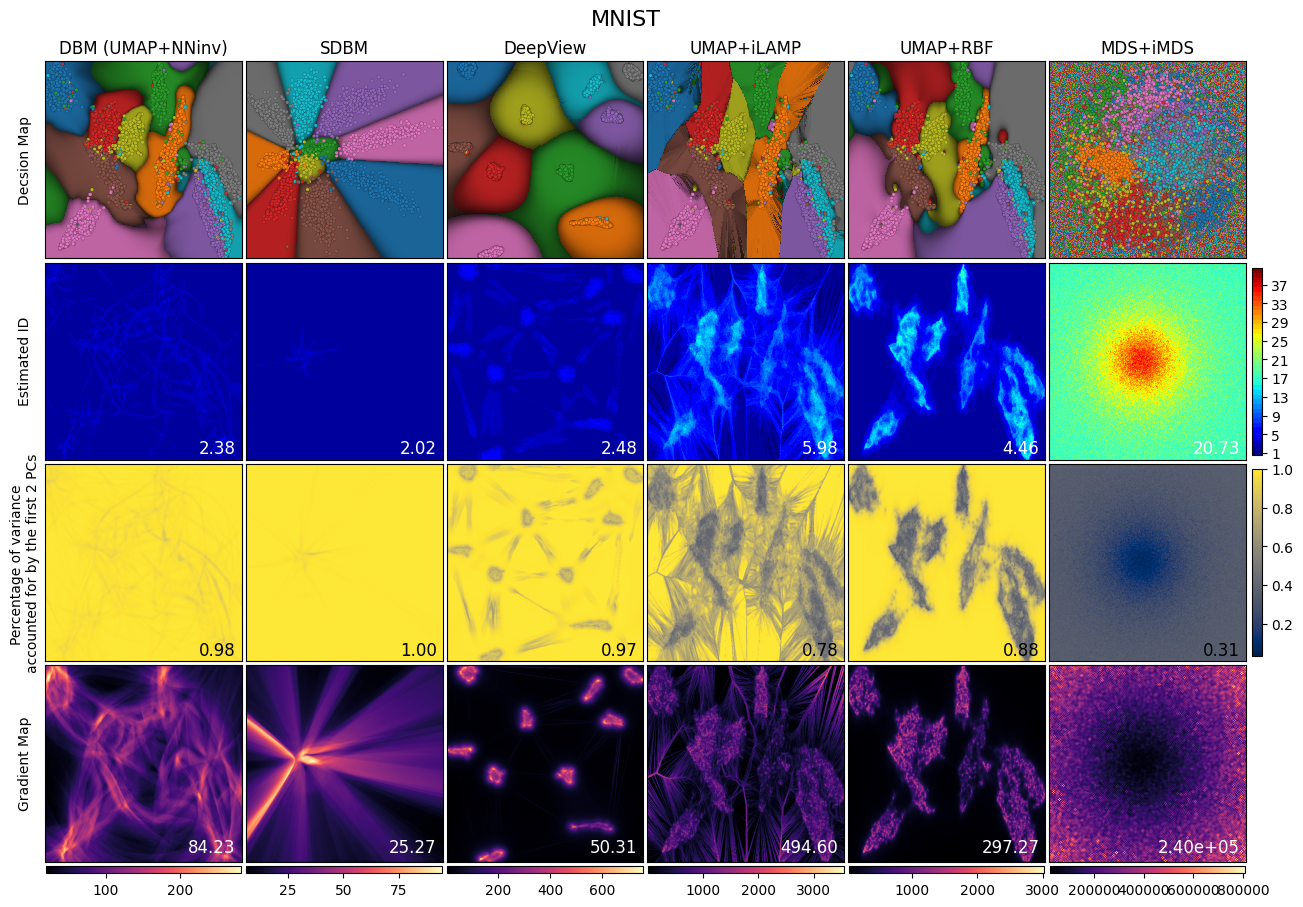

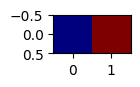

In [24]:
path = './LID_results_new_grid500_GM_iMDS_global/mnist_'
test = plot_LID2(path, threshold=threshold, title='MNIST', mode1=mode, s=6)
# plt.tight_layout()
# test.savefig('figures/mnist_minimal_var.png', dpi=300, bbox_inches='tight')
# test.savefig('../paper/PAPER_intrinsic_dim/figures/mnist_id.pdf', dpi=300, bbox_inches='tight')
if save:
    test.savefig('../paper/IVAPP24_extend_CCIS/figures/figure_CCIS/mnist_id_5cols.png', dpi=300, bbox_inches='tight')
    




### OLD

In [28]:
dim50 = plot_LID('./LID_results/blobs_dim50_n1000_', threshold=0.99, title='50D Blobs')
dim50.savefig('./figures/blobs_dim50_n1000_.png', dpi=300, bbox_inches='tight')

NameError: name 'plot_LID' is not defined

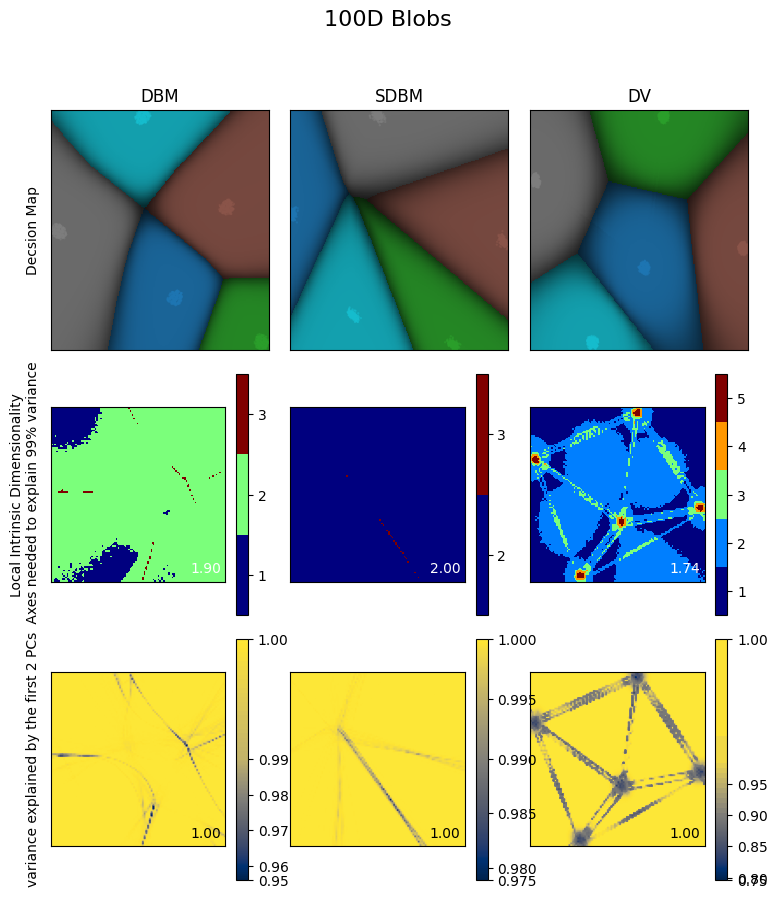

In [ ]:
dim100 = plot_LID('./LID_results/blobs_dim100_n1000_', threshold=0.99, title='100D Blobs')
dim100.savefig('./figures/blobs_dim100_n1000_.png', dpi=300)

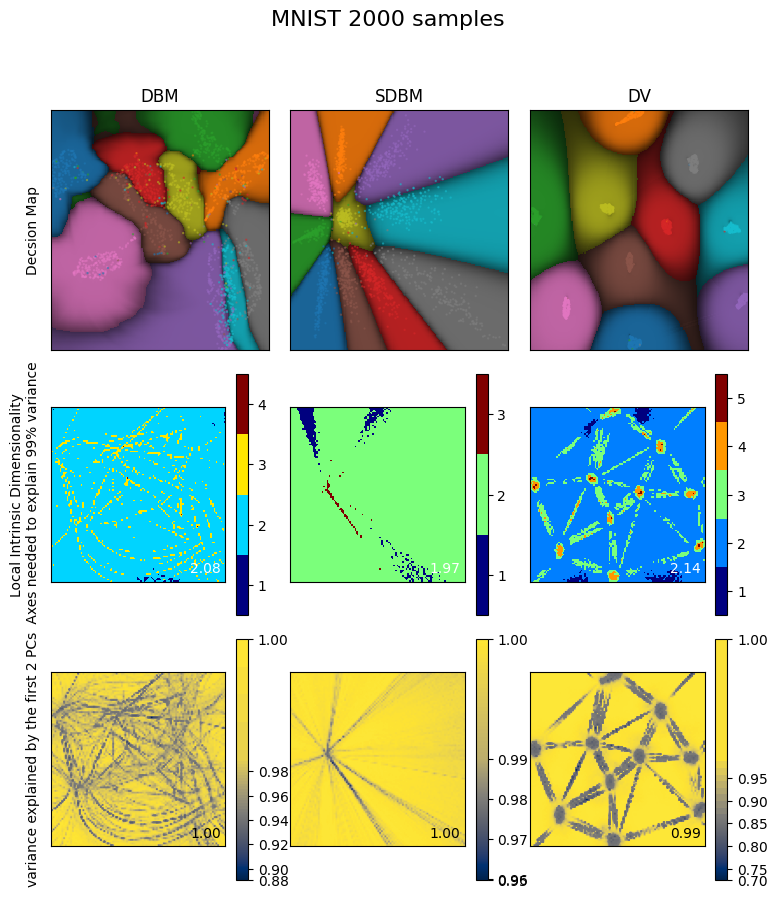

In [ ]:
mnist = plot_LID('./LID_results/mnist_', threshold=0.99, title='MNIST 2000 samples')
mnist.savefig('./figures/mnist.png', dpi=300)

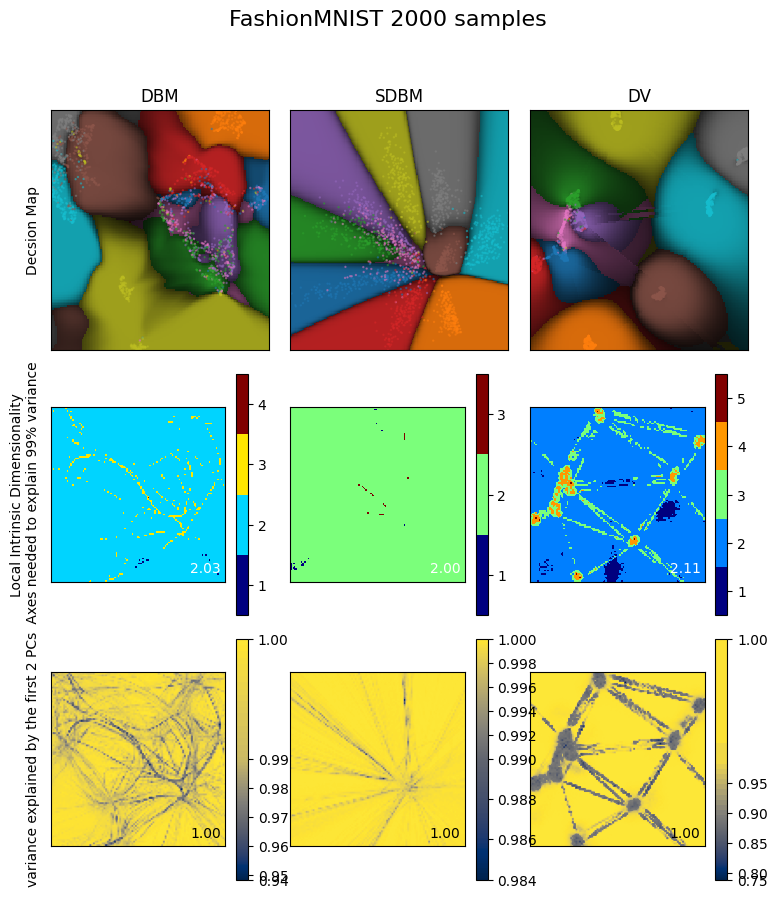

In [ ]:
mnist = plot_LID('./LID_results/fashionmnist_', threshold=0.99, title='FashionMNIST 2000 samples')
mnist.savefig('./figures/fashionmnist.png', dpi=300)

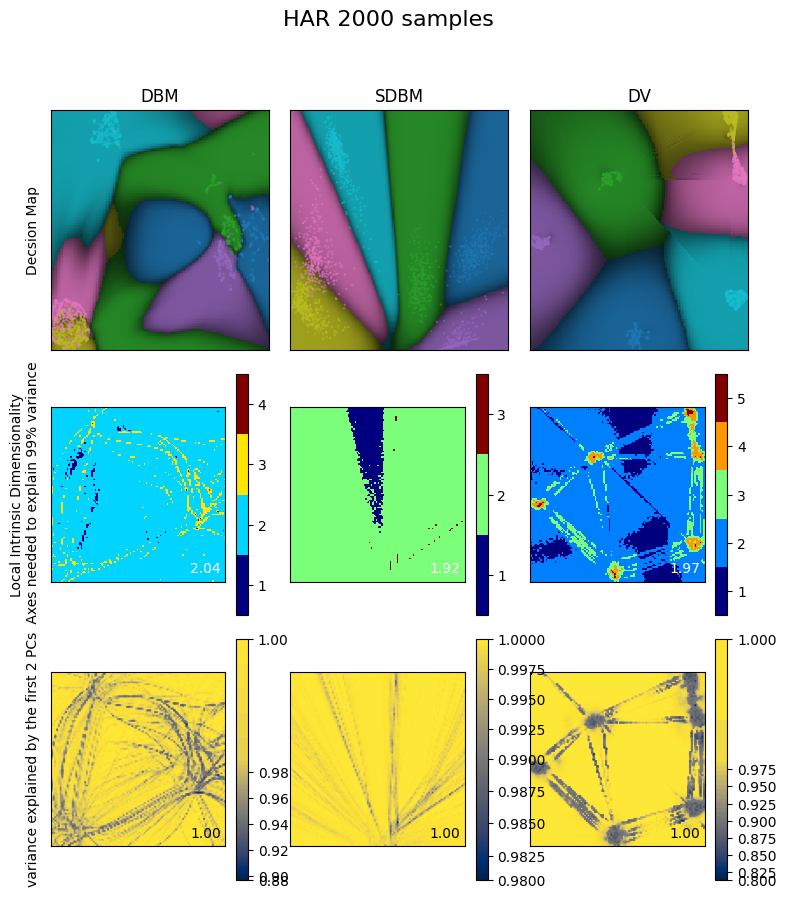

In [ ]:
mnist = plot_LID('./LID_results/har_', threshold=0.99, title='HAR 2000 samples')
mnist.savefig('./figures/har.png', dpi=300)